<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# NIRSpec FS Pipeline Notebook

**Authors**: Elena Manjavacas (emanjavacas@stsci.edu), building on the work of Peter Zeidler (zeidler@stsci.edu), Kayli Glidic (kglidic@stsci.edu), and James Muzerolle (muzerol@stsci.edu); NIRSpec branch </br>
**Last Updated**: November 4, 2024 </br>
**Pipeline Version**: 1.16.0 (Build 11.1rc1, Context jwst_1298.pmap)

**Purpose**: End-to-end calibration with the James Webb Space Telescope (JWST) pipeline is divided into three main processing stages. This notebook provides a framework for processing generic Near-Infrared Spectrograph (NIRSpec) fixed slit (FS) data through stages 1-3 of the JWST pipeline, including how to use associations for multi-exposure observations and how to interact and work with JWST datamodels. Data is assumed to be organized into three folders: science, background, and associations, as specified in the paths set up below. In most cases, editing cells outside the [Configuration](#1.-Configuration) section is unnecessary unless the standard pipeline processing options or plot parameters need to be modified.

**[Data](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))**: This notebook is set up to use observations of HD1808347 A3V standard star (point source) with the G235M grism obtained by Proposal ID (PID) 1128, Observation 6. The demo data will automatically download unless disabled (i.e., to use local files instead).

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**: This notebook was written for the above-specified pipeline version and associated build context from the JWST Calibration Reference Data System (CRDS). Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and associated CRDS context, taking advantage of bug fixes and algorithm improvements.**
However, if you use a different pipeline version or CRDS context, please read the relevant release notes ([here for the pipeline](https://github.com/spacetelescope/jwst), [here for CRDS](https://jwst-crds.stsci.edu/)) for possibly relevant changes. Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-fs-known-issues#gsc.tab=0) for this build are noted in the notebook. 

**Updates**: This notebook is regularly updated to incorporate the latest pipeline improvements. Find the most up-to-date version of this notebook [here](https://github.com/spacetelescope/jwst-pipeline-notebooks/). 

**Recent Changes**:</br>
* October 15, 2024: Converted notebook to follow standard template (kglidic@stsci.edu). </br>
* November 4, 2024: Notebook updated to JWST pipeline version 1.16.0 (Build 11.1rc1).







---

## Table of Contents

* [1. Configuration](#1.-Configuration)
* [2. Package Imports](#2.-Package-Imports)
* [3. Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
* [4. Directory Setup](#4.-Directory-Setup)
* [5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)](#5.-Stage-1:-Detector1Pipeline-(calwebb_detector1))
    * [5.1 Configure `Detector1Pipeline`](#5.1-Configure-Detector1Pipeline)
    * [5.2 Run `Detector1Pipeline`](#5.2-Run-Detector1Pipeline)
    * [5.3 Display `Detector1Pipeline` Products](#5.3-Display-Detector1Pipeline-Products)
* [6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)](#5.-Stage-2:-Spec2Pipeline-(calwebb_spec2))
    * [6.1 Configure `Spec2Pipeline`](#6.1-Configure-Spec2Pipeline)
    * [6.2 Create `Spec2Pipeline` ASN Files](#6.2-Create-Spec2Pipeline-ASN-Files)
    * [6.3 Run `Spec2Pipeline`](#6.3-Run-Spec2Pipeline)
    * [6.4 Display `Spec2Pipeline` Products](#6.4-Display-Spec2Pipeline-Products)
* [7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)](#5.-Stage-3:-Spec3Pipeline-(calwebb_spec3))
    * [7.1 Configure `Spec3Pipeline`](#7.1-Configure-Spec3Pipeline)
    * [7.2 Create `Spec3Pipeline` ASN Files](#7.2-Create-Spec3Pipeline-ASN-Files)
    * [7.3 Run `Spec3Pipeline`](#7.3-Run-Spec3Pipeline)
    * [7.4 Display `Spec3Pipeline` Products](#7.4-Display-Spec3Pipeline-Products)
* [8. Modifying the EXTRACT1D Reference File (as needed)](#8.-Modifying-the-EXTRACT1D-Reference-File-(as-needed))

---

## 1. Configuration

Set the basic parameters to configure the notebook. These parameters determine what data gets used, where data is located (if already on disk), and the type of background subtraction (if any). The list of parameters includes:

* `demo_mode`:
    * `True`: Downloads example data from the [Barbara A. Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) and processes it through the pipeline. All processing will occur in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.
    * `False`: Process your own downloaded data; provide its location.
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.
    * `bg_dir`: Directory where background observation data is stored.
* **[Backgroud subtraction methods](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_subtraction/main.html#spectroscopic-modes:~:text=the%20calwebb_image3%20pipeline.-,Spectroscopic%20Modes,%EF%83%81,-Spectroscopic%20observations%20allow)** (`True` = run, `False` = skip):
    * `master_bg`: Apply master-background subtraction in `calwebb_spec3`?
    * `pixel_bg`: Apply pixel-to-pixel background subtraction in `calwebb_spec2`?
* **Compare with MAST products** (`compare_mast`): Compare latest reductions to data products from the MAST archive?


In [1]:
# Basic import necessary for configuration.

import os
import warnings
import logging

# Control logging level: INFO, WARNING, ERROR
# Hide RuntimeWarning messages?
logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

<div class="alert alert-block alert-warning">
    
Note that `demo_mode` must be set appropriately below.
</div>

In [2]:
# Set parameters for demo_mode, data mode directories, and processing steps.

# -------------------------------DEMO MODE-----------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# ----------------------------User Mode Directories--------------------------
else:  # If demo_mode = False, look for user data in these paths.

    # Set directory paths for processing specific data; adjust to your local
    # directory setup (examples provided below).
    basedir = os.path.join(os.getcwd(), '')

    # Directory to science observation data; expects uncalibrated data in
    # sci_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    sci_dir = os.path.join(basedir, 'fs_data_02288/Obs002', '')

    # Directory to background observation data; expects uncalibrated data in
    # bg_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    # bg_dir = os.path.join(basedir, 'fs_data_02288/Obs002', '')
    bg_dir = ''  # If no background observation, use an empty string.

    # Directory to stage 2/3 association files.
    asn_dir = os.path.join(basedir, 'asn', '')

# ---------------------------Set Processing Steps----------------------------
# How should background subtraction using any dedicated backgrounds be done?
# If none are selected, data will not be background subtracted.
master_bg = False  # Master-background subtraction in spec3.
pixel_bg = True  # Pixel-based background subtraction in spec2.

compare_mast = True  # Download and compare products in MAST?

Running in demonstration mode using online example data!


---

### Set CRDS Context and Server

Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline. If the local CRDS cache directory has not been set, it will automatically be created in the home directory.

[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [3]:
# ------------------------Set CRDS context and paths------------------------
os.environ['CRDS_CONTEXT'] = 'jwst_1298.pmap'  # CRDS context for 1.16.0

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS Context:', os.environ['CRDS_CONTEXT'])
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS Context: jwst_1298.pmap
CRDS local filepath: /Users/kglidic/crds_cache
CRDS file server: https://jwst-crds.stsci.edu



---

## 2. Package Imports


In [4]:
# Use the entire available screen width for this notebook.
from IPython.display import display, HTML, JSON
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# ----------------------General Imports----------------------
import time
import copy
import glob
import json
import requests
import itertools
import numpy as np

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.io import fits
from astropy.stats import sigma_clip
from astroquery.mast import Observations
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found here: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) • 
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) • 
[Github](https://github.com/spacetelescope/jwst)

</div> 

In [6]:
# ----------------------JWST Calibration Pipeline Imports----------------------
import jwst  # Import the base JWST and CRDS packages.
from crds.client import api
from stpipe import crds_client

# JWST pipelines (each encompassing many steps).
from jwst.pipeline import Detector1Pipeline  # calwebb_detector1
from jwst.pipeline import Spec2Pipeline  # calwebb_spec2
from jwst.pipeline import Spec3Pipeline  # calwebb_spec3
from jwst.extract_1d import Extract1dStep  # Extract1D Step
from jwst import datamodels  # JWST pipeline utilities: datamodels.

print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))

JWST Calibration Pipeline Version = 1.16.0


---

### Define Convience Functions

In [7]:
def get_jwst_file(name,
                  mast_api_token=None,
                  save_dir=".",
                  redownload=False):
    """
    Retrieve a JWST data file from MAST archive and save it to a specified directory.

    Parameters
    ----------
    name : str
        File name.
    mast_api_token : str
        MAST authorization token. Get your MAST Token Here: https://auth.mast.stsci.edu/token.
    save_dir : str
        Save directory path.
    redownload : bool
        Redownload the data even if it exsits already?

    Returns
    -------
    file_path : str
        Path to newly saved file.
    """
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    headers = {"Authorization": f"token {mast_api_token}"} if mast_api_token else {}
    file_path = os.path.join(save_dir, name)

    # Check if the file already exists in the save directory.
    if os.path.exists(file_path) and not redownload:
        print(f"The file {name} already exists in the directory. Skipping download.")
        return file_path

    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()

    with open(file_path, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

    return file_path

In [8]:
def update_asn_paths(asn_files,
                     exclude_dirs=[]):
    """
    Update the expname field in an ASN file with its absolute path.

    The absolute path is determined by locating matching files in the
    current directory while excluding any files found in the specified
    excluded directories. Absolute paths ensure that the pipeline correctly
    locates the files, regardless of the ASN file's location.

    Parameters
    ----------
    asn_files : list of str
        List of ASN files to update.
    exclude_dirs : list of str, optional
        List of directories to exclude in the search.

    Returns
    -------
    None.
    """

    # Ensure asn_files is a list.
    asn_files = [asn_files] if isinstance(asn_files, str) else asn_files

    for asn in asn_files:
        with open(asn, 'r') as file:
            data = json.load(file)

        update = False

        # Loop through each product and its members.
        for product in data['products']:
            for member in product['members']:
                search_pattern = f"**/{member['expname']}"
                filtered_files = [f for f in glob.glob(os.path.join(os.getcwd(),
                                  search_pattern), recursive=True) if not
                                  any(f.startswith(exc) for exc in exclude_dirs)]
                if len(filtered_files) > 0:
                    member['expname'] = filtered_files[0]
                    update = True

        basn = os.path.basename(asn)
        if update:
            try:
                with open(asn, 'w') as json_file:
                    json.dump(data, json_file, indent=4)
                print(f"{basn} 'expname' paths have been updated to absolute paths!")
            except Exception as e:
                print(f"Error saving updated file {asn}: {e}")
        else:
            print(f"{basn} 'expname' paths NOT updated! Paths may be absolute.")

In [9]:
def display_rate(rates,
                 slits_models=[],
                 integration=0,
                 extname='data',
                 cmap='viridis',
                 bad_color=(1,0.7,0.7),
                 vmin=None,
                 vmax=None,
                 scale='asinh',
                 aspect='auto',
                 title_prefix=None,
                 title_path=False,
                 save_plot=False):
    """
    Display countrate images.

    Parameters
    ----------
    rates : list of str
        A list of RATE[INTS] files to be displayed.
    slits_models : list of str, optional
        A list of CAL[INTS] or S2D files containing the slit models.
        If provided, slit cutouts will be overlaid on the countrate images.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
    extname : str, optional
        The name of the data extension to extract from ('data', 'dq', etc.).
    cmap : str, optional
        Colormap to use for displaying the image. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for NaN pixels. Default is light red (1, 0.7, 0.7).
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    save_plot : bool, optional
        If True, saves the plot as a PNG file. Default is False.
    """

    # -------------------------------Check Inputs-------------------------------
    rates = [rates] if isinstance(rates, str) else rates
    slits_models = [slits_models] if isinstance(slits_models, str) else slits_models
    nrates = len(rates)

    # ------------------------------Set up figures------------------------------
    fig, axes = plt.subplots(nrates, 1, figsize=(12, 12 * nrates),
                             sharex=True, height_ratios=[1] * nrates)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = [axes] if nrates == 1 else axes

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)

    # ---------------------------Plot countrate image---------------------------
    for i, (rate, cal) in enumerate(itertools.zip_longest(rates,
                                                          slits_models,
                                                          fillvalue=None)):

        # -------------------Open files as JWST datamodels-------------------
        model = datamodels.open(rate)
        slits_model = datamodels.open(cal) if cal else None

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # ----------------Plot the countrate image & colorbar---------------
        plt.subplots_adjust(left=0.05, right=0.85)
        im = axes[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')
        units = model.meta.bunit_data
        cbar_ax = fig.add_axes([axes[i].get_position().x1 + 0.02,
                                axes[i].get_position().y0, 0.02,
                                axes[i].get_position().height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(units, fontsize=12)

        # -----------------Draw slits and label source ids------------------
        # slits_model can be s2d/cal from spec2 - contains slit models for all sources.
        if slits_model:
            slit_patches = []
            for slit in slits_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart),
                                        slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                y = slit.ystart + slit.ysize / 2
                x = slit.xstart if 'nrs1' in rate else slit.xstart + slit.xsize
                ha = 'right' if 'nrs1' in rate else 'left'
                plt.text(x, y, slit.source_id, color='w', ha=ha, va='center',
                         fontsize=7, path_effects=[], weight='bold')
            axes[i].add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

        # -----------------Construct title and axis labels------------------
        filename = model.meta.filename
        title = (f"{title_prefix + ' ' if title_prefix else ''}"
                 f"{filename if title_path else os.path.basename(filename)}")
        if integration is not None:
            title = title.replace('rateints', f'rateints[{integration}]')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Pixel Column", fontsize=12)
        axes[i].set_ylabel("Pixel Row", fontsize=12)

        # -------------------------Save the figure?-------------------------
        if save_plot:
            save_plot = rate.replace('fits', 'png')
            if integration:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
            fig.savefig(save_plot, dpi=200)

        fig.show()

In [10]:
def display_spectra(spectra,
                    compare_x1d=None,
                    compare_mast=None,
                    integration=None,
                    extname='data',
                    source_id=1,
                    source_type=None,
                    expand_wavelength_gap=True,
                    plot_resample=True,
                    plot_errors=False,
                    cmap='viridis',
                    bad_color=(1,0.7,0.7),
                    aspect='auto',
                    vmin=None,
                    vmax=None,
                    scale='asinh',
                    title_prefix=None,
                    title_path=False,
                    y_limits=None,
                    is_stage3=False):

    """
    Display 2D and 1D spectra (Stage 2/3).

    Parameters
    ----------
    spectra : list of str
        A list of data products (e.g., CAL, S2D, X1D files).
    compare_x1d : list of str, optional
        A list of 1D spectra for comparison (X1D files).
    compare_mast : list of str, optional
        A list of 1D spectra from MAST for comparison (X1D files).
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
     extname : str, optional
        The name of the data extension to extract ('data', 'dq', etc.).
    source_id : int or str, optional
        Identifier for the source/slit to be displayed. Default is 1.
    source_type : str, optional
        Override data source type ('POINT' or 'EXTENDED').
    expand_wavelength_gap : bool, optional
        If True, expands gaps in the wavelength data for better visualization.
    plot_resample : bool, optional
        If True, plots resampled (S2D) data products;
        otherwise, plots calibrated (CAL) data. Default is True.
    plot_errors : bool, optional
        If True, plots the error bands for the 1D spectra. Default is False.
    cmap : str, optional
        Colormap to use for displaying the images. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for bad pixels. Default is light red (1, 0.7, 0.7).
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    y_limits : tuple of float, optional
        Limits for the y-axis of the 1D spectrum plot.
        If None, limits are determined from the data.
    is_stage3 : bool, optional
        Plot stage 3 products? Default is False.

    Returns
    -------
    None.
    """

    # ---------------------------------Check Inputs---------------------------------
    spectra = [spectra] if isinstance(spectra, str) else spectra
    compare_x1d = [compare_x1d] if isinstance(compare_x1d, str) else compare_x1d
    compare_mast = [compare_mast] if isinstance(compare_mast, str) else compare_mast

    # Plot stage 3 products?
    if is_stage3:

        # Stage 3 products should include the source_id in the filename.
        # Sort based on filename rather than open all.
        def filter_prod(products, source_id):
            """Filter products based on the source_id."""
            return [f for f in products if source_id.lower() in f and
                    ('FXD_SLIT' not in fits.getheader(f, ext=0) or
                     fits.getheader(f, ext=0)['FXD_SLIT'].lower() == source_id.lower())]

        spectra = filter_prod(spectra, source_id)
        compare_x1d = filter_prod(compare_x1d, source_id) if compare_x1d else None
        compare_mast = filter_prod(compare_mast, source_id) if compare_mast else None

    ftypes = {ftype: [f for f in spectra
                      if ftype in f] for ftype in ["cal", "s2d", "x1d"]}
    products = sorted(ftypes['s2d']) if plot_resample else sorted(ftypes['cal'])
    if not products:
        raise ValueError("No valid data products found for plotting.")

    # --------------------------------Set up figures-------------------------------
    total_plots = len(products) + bool(ftypes['x1d'])
    height_ratios = [1] * len(products) + ([3] if bool(ftypes['x1d']) else [])
    fig, axes = plt.subplots(total_plots, 1, figsize=(15, 5*total_plots),
                             sharex=False, height_ratios=height_ratios)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax2d, ax1d = (axes[:-1], axes[-1]) if bool(ftypes['x1d']) else (axes, None)

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)
    colors = plt.get_cmap('tab10').colors
    color_cycle = itertools.cycle(colors)

    # ---------------------------------Plot spectra--------------------------------
    for i, product in enumerate(products):
        model = datamodels.open(product)  # Open files as JWST datamodels.

        # Extract the correct 2D source spectrum if there are multiple.
        slit_m = model
        if 'slits' in model:
            slits = model.slits
            slit_m = next((s for s in slits
                           if getattr(s, 'name', None) == source_id), None)
            slit_m = slit_m or next((s for s in model.slits
                                     if s.source_id == source_id), None)
            if not slit_m:
                print(f"'{source_id}' not found/invalid.")
                print(f"Available source_ids: {[s.source_id for s in slits][:5]}")
                break

        # Check if 'fixed_slit' exists, otherwise fall back to 'slitlet_id'
        slit_name = (f"SLIT: {getattr(slit_m, 'name', None) or slit_m.slitlet_id}, "
                     f"SOURCE: {getattr(slit_m, 'source_id', '')}")

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(slit_m, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # -----------Convert from pixels to wavelength (x-axis)--------------
        wcsobj = slit_m.meta.wcs  # Obtaining the WCS object from the meta data.
        y, x = np.mgrid[:slit_m.data.shape[0], :slit_m.data.shape[1]]
        # Coordinate transform from detector space (pixels) to sky (RA, DEC).
        det2sky = wcsobj.get_transform('detector','world')
        ra, dec, s2dwave = det2sky(x, y)  # RA/Dec, wavelength (microns) for each pixel.
        s2dwaves = s2dwave[0, :] # Single row since this is the rectified spectrum.
        x_arr = np.arange(0, slit_m.data.shape[1], int(len(slit_m.data[1]) / 4))
        wav = np.round(s2dwaves[x_arr], 2)  # Populating the wavelength array.
        ax2d[i].set_xticks(x_arr, wav)

        # xticks = np.arange(np.ceil(wave_1d[0]), wave_1d[-1], 0.2)
        # xtick_pos = np.interp(xticks, wave_1d, np.arange(num_waves))
        # ax1d.set_xticks(xtick_pos)
        # ax1d.set_xticklabels([f'{xtick:.1f}' for xtick in xticks])

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)


        # -------------------------Plot 1D Spectra-------------------------
        for prods_1d, prefix in [(sorted(ftypes['x1d']),  f'{title_prefix} '),
                                 (compare_x1d, 'RE-EXTRACTION '),
                                 (compare_mast, 'MAST ')]:
            if prods_1d:

                model_1d = datamodels.open(prods_1d[i])
                specs = model_1d.spec
                spec = next((s for s in specs if
                             getattr(s, 'name', None) == source_id), None)
                spec = spec or next((s for s in specs
                                     if s.source_id == source_id), None)

                if spec:
                    tab = spec.spec_table
                    source_type = source_type if source_type else slit_m.source_type
                    wave = tab.WAVELENGTH
                    flux = tab.FLUX if source_type == 'POINT' else tab.SURF_BRIGHT
                    errs = tab.FLUX_ERROR if source_type == 'POINT' else tab.SB_ERROR

                    # Expand the array to visualize the wavelength gap.
                    if expand_wavelength_gap:
                        dx1d_wave = wave[1:] - wave[:-1]
                        igap = np.argmax(dx1d_wave)
                        dx_replace = (dx1d_wave[igap-1] + dx1d_wave[igap+1]) / 2.
                        nfill = int(np.round(np.nanmax(dx1d_wave) / dx_replace))

                        if nfill > 1:
                            print(f"Expanding wavelength gap {wave[igap]:.2f} "
                                  f"-- {wave[igap+1]:.2f} μm")

                            wave_fill = np.mgrid[wave[igap]:wave[igap+1]:(nfill+1)*1j]
                            wave = np.concatenate([wave[:igap+1],
                                                   wave_fill[1:-1],
                                                   wave[igap+1:]])

                            if prefix != 'RE-EXTRACTION ':
                                num_rows, num_waves = data_2d.shape
                                fill_2d = np.zeros(shape=(num_rows, nfill-1))*np.nan
                                data_2d = np.concatenate([data_2d[:, :igap+1],
                                                          fill_2d, data_2d[:, igap+1:]],
                                                          axis=1)

                            fill = np.zeros(shape=(nfill-1)) * np.nan
                            flux = np.concatenate([flux[:igap+1], fill, flux[igap+1:]])
                            errs = np.concatenate([errs[:igap+1], fill, errs[igap+1:]])
                    else:
                        nfill = 0

                    # ----------------Construct legends and annotations-----------------
                    detector = slit_m.meta.instrument.detector
                    ffilter = slit_m.meta.instrument.filter
                    grating = slit_m.meta.instrument.grating
                    dither = model.meta.dither.position_number
                    label_2d = f'{grating}/{ffilter}'
                    label_1d = f'{detector} ({grating}/{ffilter})'
                    if not is_stage3:
                        label_2d = f'Dither/Nod {dither} ({label_2d})'
                        label_1d = (f'{prefix} Dither/Nod {dither} {label_1d}')
                    else:
                        label_1d = f'{prefix}{label_1d}'
                    ax2d[i].annotate(label_2d, xy=(1, 1), xycoords='axes fraction',
                                     xytext=(-10, -10), textcoords='offset points',
                                     bbox=dict(boxstyle="round,pad=0.3",
                                               edgecolor='white',
                                               facecolor='white', alpha=0.8),
                                     fontsize=12, ha='right', va='top')

                    title_2d = (f"{title_prefix + ' ' if title_prefix else ''}"
                                f"{model.meta.filename} | {slit_name}")
                    if integration:
                        title_2d = title_2d.replace('.fits', f'[{integration}].fits')
                    ax2d[i].set_title(title_2d, fontsize=14)
                    if not bool(ftypes['x1d']):
                        ax2d[i].set_xlabel("Wavelength (μm)", fontsize=12)
                    ax2d[i].set_ylabel("Pixel Row", fontsize=12)
                    ax2d[i].legend(fontsize=12)

                    # ------------------------------------------------------------------

                    num_waves = len(wave)
                    color = next(color_cycle)
                    ax1d.step(wave, flux, lw=1, label=label_1d, color=color)
                    if plot_errors:
                        ax1d.fill_between(np.arange(num_waves), flux - errs,
                                          flux + errs, color='grey', alpha=0.3)
                    ax1d.legend(fontsize=12)
                    ax1d.set_title(f"{title_prefix + ' ' if title_prefix else ''}"
                       f"Extracted 1D Spectra | {slit_name}", fontsize=14)
                    ax1d.set_ylabel("Flux (Jy)" if source_type == 'POINT'
                                    else "Surface Brightness (MJy/sr)", fontsize=12)
                    ax1d.set_xlabel("Wavelength (μm)", fontsize=12)

                    ax1d.set_ylim(y_limits or (np.nanpercentile(flux, 1),
                                               np.nanpercentile(flux, 99.5)))

                    # --------------------Plot the 2D spectra & colorbar---------------
                    plt.subplots_adjust(left=0.05, right=0.85)
                    im = ax2d[i].imshow(data_2d, origin='lower', cmap=cmap, norm=norm,
                                        aspect=aspect, interpolation='nearest')
                    units = slit_m.meta.bunit_data
                    cbar_ax = fig.add_axes([ax2d[i].get_position().x1 + 0.02,
                                            ax2d[i].get_position().y0, 0.02,
                                            ax2d[i].get_position().height])
                    cbar = fig.colorbar(im, cax=cbar_ax)
                    cbar.set_label(units, fontsize=12)

                    # ----------------------Add extraction region---------------------
                    ystart, ystop, xstart, xstop = (spec.extraction_ystart - 1,
                                                    spec.extraction_ystop - 1,
                                                    spec.extraction_xstart - 1,
                                                    spec.extraction_xstop - 1)
                    extract_width = ystop - ystart + 1
                    box = Rectangle((xstart, ystart), xstop - xstart+nfill,
                                    extract_width, fc='None', ec=color,
                                    lw=2, label=prefix)
                    ax2d[i].add_patch(box)
                    ax2d[i].legend()


---

## 3. Demo Mode Setup (ignore if not using demo data)

<div class="alert alert-block alert-info">

To download data from MAST, you may need to input an authorization token. Get your MAST token here: https://auth.mast.stsci.edu/token. </br>
Additionally, follow [`astroquery` installation procedures](https://astroquery.readthedocs.io/en/latest/index.html#) to properly run these cells. 
    
</div> 

If running in demonstration mode, set up the program information to retrieve the uncalibrated data (`_uncal.fits`) automatically from MAST using `astroquery`. MAST provides flexibility by allowing searches based on proposal ID and observation ID, rather than relying solely on filenames. More information about the JWST file naming conventions can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).


The FS demo data in this notebook is from the [NIRSpec calibration program 1128](https://www.stsci.edu/jwst/science-execution/program-information?id=1128) and features observations of HD1808347 (point source) using the G235M grism. The program setup is briefly summarized in the table below.


| Demo Target: HD1808347 A3V Standard Star |       |   | 
|:-----------:|:-------:|:---:|
| PROGRAM | 01128 | Program number | 
| OBSERVTN | 006 | Observation number | 
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-fixed-slits-spectroscopy#gsc.tab=0:~:text=%C2%A0Table%202.%20NIRSpec%20A%20fixed%20slit%C2%A0instrument%20configurations%2C%20resolutions%2C%20and%20wavelength%20ranges) | G235M/F170LP | λ: 1.66–3.17 μm (a medium resolution, R ~ 1000) |
| SUBARRAY | SUBS200A1 | Subarray used | 
| NINTS | 2 | Number of integrations in exposure |           
| NGROUPS | 30 | Number of groups in integration |
| DURATION | 96.637 [s] | Total duration of one exposure |   
| READPATT | NRSRAPID | Readout pattern | 
| PATTTYPE | 3-POINT-NOD | Primary dither pattern type |  
| NUMDTHPT | 3 |  Total number of points in pattern |                           
| SRCTYAPT | POINT | Source type selected in APT |

> **Note:** The presence of a physical gap between detectors affects high-resolution FS observations because the spectra are long enough to span both NIRSpec detectors. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-fs-operations/nirspec-fs-wavelength-ranges-and-gaps#gsc.tab=0)

In [11]:
# Set up the program information for demo mode.

if demo_mode:

    print('Running in demonstration mode. '
          'Example data will be downloaded from MAST!')

    # NOTE:
    # The data in this notebook is public and does not require a token.
    # For other data sets, you may need to provide a token.
    # Observations.login(token=None)

    # --------------Program and observation information--------------
    program = "01128"
    sci_observtn = "006"
    bg_observtn = None
    filters = ["F170LP;G235M"]

    # ----------Define the base and observation directories----------
    basedir = os.path.join('.', f'fs_data_{program}')
    sci_dir = os.path.join(basedir, f'Obs{sci_observtn}')
    bg_dir = os.path.join(basedir, f'Obs{bg_observtn}') if bg_observtn else ''
    asn_dir = os.path.join(basedir, 'asn/')
    uncal_dir = os.path.join(sci_dir, 'uncal/')
    uncal_bgdir = os.path.join(bg_dir, 'uncal/') if bg_observtn else ''

    os.makedirs(uncal_dir, exist_ok=True)
    os.makedirs(asn_dir, exist_ok=True)
    if bg_observtn:
        os.makedirs(uncal_bgdir, exist_ok=True)

Running in demonstration mode. Example data will be downloaded from MAST!


In [12]:
# Obtain a list of observation IDs for the specified demo program.

if demo_mode:

    # --------------------SCIENCE Observation--------------------
    sci_obs_id_table = Observations.query_criteria(
        instrument_name=['NIRSPEC/SLIT'],
        provenance_name=["CALJWST"],
        obs_id=[f'*{program}*{sci_observtn}*'])

    # ------------------BACKGROUND Observation-------------------
    bg_obs_id_table = Observations.query_criteria(
        instrument_name=['NIRSPEC/SLIT'],
        provenance_name=["CALJWST"],
        obs_id=[f'*{program}*{bg_observtn}*'])



The demo dataset consists of six `_uncal.fits` files, each approximately 15 MB in size.

In [13]:
# Convert visits into a list of uncalibrated data and ASN files.

if demo_mode:

    file_criteria = {'filters': filters, 'calib_level': [1],
                     'productSubGroupDescription': 'UNCAL'}
    asn_criteria = {'filters': filters, 'calib_level': [2, 3],
                     'productSubGroupDescription': 'ASN'}

    # Initialize lists for science, background, and ASN files.
    sci_downloads, bg_downloads, asn_downloads = [], [], []

    pfilter = Observations.filter_products  # Alias for filter_products method.

    # ----------Identify uncalibrated SCIENCE files associated with each visit----------
    for exposure in sci_obs_id_table:
        sci_products = Observations.get_product_list(exposure)
        asn_downloads.extend(pfilter(sci_products, **asn_criteria)['dataURI'])

        # Filter for full-size science files (exclude smaller confirmation images).
        avg_sci_size = np.nanmean(sci_products['size'])
        sci_products = sci_products[sci_products['size'] > avg_sci_size]
        sci_downloads.extend(pfilter(sci_products, **file_criteria)['dataURI'])

    # --------Identify uncalibrated BACKGROUND files associated with each visit---------
    for exposure in bg_obs_id_table:
        bg_products = Observations.get_product_list(exposure)

        # Filter for full-size background files (exclude smaller confirmation images).
        avg_bg_size = np.nanmean(bg_products['size'])
        bg_products = sci_products[bg_products['size'] > avg_bg_size]
        bg_downloads.extend(pfilter(bg_products, **file_criteria)['dataURI'])

    # Filter out other observations and remove duplicates.
    sci_downloads = {f for f in sci_downloads if f"jw{program}{sci_observtn}" in f}
    bg_downloads = {f for f in bg_downloads if f"jw{program}{bg_observtn}" in f}
    asn_downloads = {f for f in asn_downloads if any(f"-{p}{sci_observtn}_" in f
                                                     for p in ["o", "c?"])}

    print(f"Science files selected for downloading: {len(sci_downloads)}")
    print(f"Background files selected for downloading: {len(bg_downloads)}")
    print(f"ASN files selected for downloading: {len(asn_downloads)}")

Science files selected for downloading: 6
Background files selected for downloading: 0
ASN files selected for downloading: 4


In [14]:
# Download data and place them into the appropriate directories.

if demo_mode:

    for file in sci_downloads:
        sci_manifest = Observations.download_file(file, local_path=uncal_dir)
    for file in bg_downloads:
        bg_manifest = Observations.download_file(file, local_path=uncal_bgdir)
    for file in asn_downloads:
        asn_manifest = Observations.download_file(file, local_path=asn_dir)

<div class="alert alert-block alert-warning">

**Warning**: If this notebook is halted during this step, the downloaded file may be incomplete, and cause crashes later on!
</div>

---

## 4. Directory Setup
Set up detailed paths to input/output stages here.

In [15]:
# Define/create output subdirectories to keep data products organized.

# -----------------------------Science Directories------------------------------
uncal_dir = os.path.join(sci_dir, 'uncal/')  # Uncalibrated pipeline inputs.
det1_dir = os.path.join(sci_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_dir = os.path.join(sci_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.
spec3_dir = os.path.join(sci_dir, 'stage3/')  # calwebb_spec3 pipeline outputs.

os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(spec3_dir, exist_ok=True)

# ---------------------------Background Directories-----------------------------
uncal_bgdir = os.path.join(bg_dir, 'uncal/')  # Uncalibrated pipeline inputs.
det1_bgdir = os.path.join(bg_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_bgdir = os.path.join(bg_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.

if bg_dir:
    os.makedirs(det1_bgdir, exist_ok=True)
    os.makedirs(spec2_bgdir, exist_ok=True)

# -------------------------------MAST Directory---------------------------------
mast_products_dir = os.path.join(basedir, 'mast_products/')  # MAST products.

if compare_mast:
    os.makedirs(mast_products_dir, exist_ok=True)

---

## 5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)

In this section, we process the data through the `calwebb_detector1` pipeline to create Stage 1 data products.

* **Input**: Raw exposure (`_uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
* **Output**: Uncalibrated countrate (slope) image in units of DN/s:
    * `_rate.fits`: A single countrate image averaged over multiple integrations (if available).
    * `_rateints.fits`: Countrate images for each integration, saved in multiple extensions.

The `Detector1Pipeline` applies basic detector-level corrections on a group-by-group basis, followed by ramp fitting for all exposure types, commonly referred to as "ramps-to-slopes" processing. 

---

### 5.1 Configure `Detector1Pipeline`

The `Detector1Pipeline` has the following steps available for NIRSpec FS:

> * `group_scale` : Rescales pixel values to correct for improper onboard frame averaging.
> * `dq_init` : Initializes the data quality (DQ) flags for the input data.
> * `saturation` : Flags pixels at or below the A/D floor or above the saturation threshold.
> * `superbias` : Subtracts the superbias reference file from the input data.
> * `refpix` : Use reference pixels to correct bias drifts.
> * `linearity` : Applies a correction for non-linear detector response.   
> * `dark_current` : Subtracts the dark current reference file from the input data.
> * `jump` : Performs CR/jump detection on each ramp integration within an exposure.
> * `clean_flicker_noise`: Removes flicker (1/f) noise from calibrated ramp images (similar to `nsclean` in spec2).
> * `ramp_fit` : Determines the mean count rate (counts per second) for each pixel by performing a linear fit to the input data.
> * `gain_scale` : Corrects pixel values for non-standard gain settings, primarily in NIRSpec subarray data.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

Below, we set up a dictionary that defines how the `Detector1Pipeline` should be configured for FS data. 

<div class="alert alert-warning">
  To override specific steps and reference files, use the examples below.
</div>


In [16]:
# Set up a dictionary to define how the Detector1 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['superbias'], det1dict['refpix'] = {}, {}
det1dict['linearity'], det1dict['dark_current'] = {}, {}
det1dict['jump'], det1dict['ramp_fit'], det1dict['gain_scale']= {}, {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
# det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
# det1dict['superbias']['override_superbias'] = 'myfile.fits' # Bias subtraction
# det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
det1dict['linearity']['skip'] = False  # This is the default.

# Turn on multi-core processing (off by default).
# Choose what fraction of cores to use (quarter, half, or all).
det1dict['jump']['maximum_cores'] = 'half'
# det1dict['ramp_fit']['maximum_cores'] = 'half'

# Turn on detection of cosmic ray snowballs (on by default).
det1dict['jump']['expand_large_events'] = True
det1dict['jump']['expand_factor'] = 3  # (default 2)

# Suppress computations for saturated ramps
# with only one good (unsaturated) sample (default True)?
det1dict['ramp_fit']['suppress_one_group'] = False

<div class="alert alert-info">
    
Many exposures are affected by artifacts known as [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts#gsc.tab=0) caused by large cosmic ray events. These artifacts are particularly significant in deep exposures with long integration times, with an estimated rate of one snowball per detector (FULL FRAME) per 20 seconds. To expand the number of pixels flagged as jumps around large cosmic ray events, set `expand_large_events` to True. An `expand_factor` of 3 works well for NIRSpec observations to cover most snowballs.
</div>

<div class="alert alert-info">
    
JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. This noise manifests as faint banding along the detector's slow axis and varies from column to column. For NIRSpec data, the primary pipeline algorithm to address 1/f noise is `nsclean` in the `Spec2Pipeline`. (Rauscher 2023) but is off by default.

An additional 1/f noise-cleaning algorithm, `clean_flicker_noise`, has been implemented at the group stage in the `Detector1Pipeline`. This step is also off by default.
</div>

---

### 5.2 Run `Detector1Pipeline`

Run the science files and, if available, any background files through the `calwebb_detector1` pipeline using the `.call()` method. 

We use `.call()` instead of `.run()` to ensure that the latest default parameters from CRDS are applied ([ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html)).

This stage takes approximately 2 minutes to process six `_uncal.fits` files from the demo data.

In [17]:
# Final list of UNCAL files ready for Stage 1 processing.
uncal_sci = sorted(glob.glob(uncal_dir + '*uncal.fits'))
uncal_bg = sorted(glob.glob(uncal_bgdir + '*uncal.fits'))

print(f"Science UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_sci))
print(f"Background UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_bg))

Science UNCAL Files:
--------------------
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00001_nrs1_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00001_nrs2_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00002_nrs1_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00002_nrs2_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00003_nrs1_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00003_nrs2_uncal.fits
Background UNCAL Files:
--------------------



In [18]:
# Run Stage 1 pipeline using the custom det1dict dictionary.

start = time.time()

# --------------------------Science UNCAL files--------------------------
for uncal_file in sorted(glob.glob(uncal_dir + '*uncal.fits')):

    print(f"Applying Stage 1 Corrections & Calibrations to: "
          f"{os.path.basename(uncal_file)}")

    det1_result = Detector1Pipeline.call(uncal_file,
                                         save_results=True,
                                         steps=det1dict,
                                         output_dir=det1_dir)

# ------------------------Background UNCAL files-------------------------
for uncal_file in sorted(glob.glob(uncal_bgdir + '*uncal.fits')):

    print(f"Applying Stage 1 Corrections & Calibrations to: "
          f"{os.path.basename(uncal_file)}")

    det1bg_result = Detector1Pipeline.call(uncal_file,
                                           save_results=True,
                                           steps=det1dict,
                                           output_dir=det1_bgdir)

print(f"\nRun time: {round((time.time()-start)/60.0, 1)} min")
print("Hurray ... Stage 1 has been completed!\n")

Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00001_nrs1_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00001_nrs2_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00002_nrs1_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00002_nrs2_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00003_nrs1_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00003_nrs2_uncal.fits

Run time: 2.1 min
Hurray ... Stage 1 has been completed!



In [19]:
# Print output result details:
# det1_result.__dict__  # View entire contents.
# det1_result.meta.filename
# det1_result.data.shape

---

### 5.3 Display `Detector1Pipeline` Products

Inspect the Stage 1 slope products. If `compare_mast` is enabled, an additional plot will compare the reprocessed results with MAST products, which were processed using the default pipeline parameters. Reprocessing with a newer pipeline version may also result in noticeable improvements in data quality.

In [20]:
# Final list of RATE[INTS] files ready for Stage 2 processing.
rate_sci = sorted(glob.glob(det1_dir + '*_rate*.fits'))
rate_bg = sorted(glob.glob(det1_bgdir + '*_rate*.fits'))

print(f"SCIENCE | RATE[INTS] Files:\n{'-'*20}\n" + "\n".join(rate_sci))
print(f"BACKGROUND | RATE[INTS] Files:\n{'-'*20}\n" + "\n".join(rate_bg))

SCIENCE | RATE[INTS] Files:
--------------------
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rateints.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs2_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs2_rateints.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rateints.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs2_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs2_rateints.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rateints.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs2_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs2_rateints.fits
BACKGROUND | RATE[INTS] Files:
--------------------



The file jw01128006001_0310c_00003_nrs2_rateints.fits already exists in the directory. Skipping download.


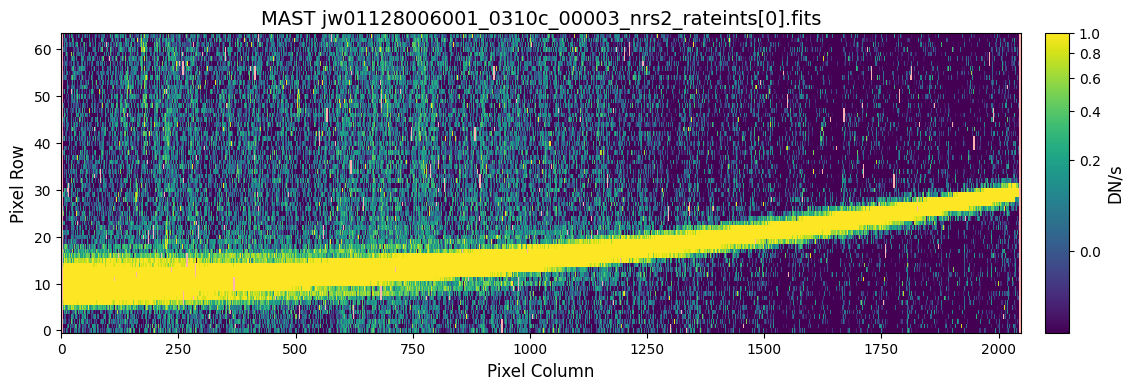

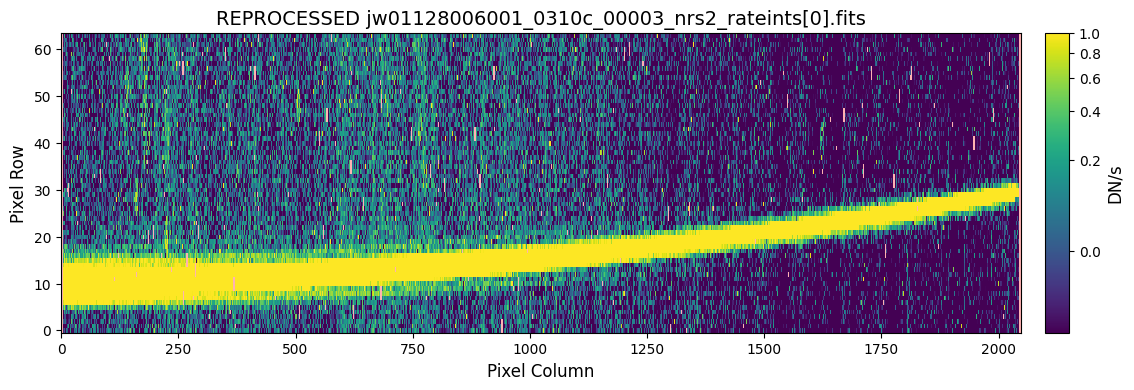

In [21]:
rate_file = rate_sci[-1]  # Show the last rate file, as an example.

# Compare to the data product in MAST?
if compare_mast:
    # Download the MAST data product (or load it if you've downloaded it already).
    MAST_rate = get_jwst_file(os.path.basename(rate_file), save_dir=mast_products_dir)
    display_rate(MAST_rate, vmin=-0.1, vmax=1, scale='asinh',
                 aspect=10, title_prefix='MAST')  #, extname='dq')

display_rate(rate_file, vmin=-0.1, vmax=1, scale='asinh',
             aspect=10, title_prefix='REPROCESSED')  #, extname='dq')

---

## 6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)

In this section, we process our countrate (slope) image products from Stage 1 (`calwebb_detector1`) through the Spec2 (`calwebb_spec2`) pipeline to create Stage 2 data products.

* **Input**: A single countrate (slope) image (`_rate[ints].fits`) or an association file listing multiple inputs.
* **Output**: Calibrated products (rectified and unrectified) and 1D spectra.
	* `_cal[ints].fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
	* `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows). 
	* `_x1d[ints].fits`: Extracted 1D spectroscopic data (wavelength vs. flux).
      
The `Spec2Pipeline` applies additional instrumental corrections and calibrations (e.g., slit loss, path loss, etc.,) to countrate products that result in a fully calibrated individual exposure (per nod/dither position). The `Spec2Pipeline` also converts countrate products from units of DN/s to flux (Jy) for point sources and surface brightness (MJy/sr) for extended sources.

---

### 6.1 Configure `Spec2Pipeline`

The `Spec2Pipeline` has the following steps available for NIRSpec FS:

> * `assign_wcs`: Assigns wavelength solution for spectra.
> * `nsclean`: Cleans 1/f noise.
> * `bkg_subtract`: Performs image subtraction for background removal.
> * `extract_2d` : Extracts 2D arrays from spectral images.
> * `srctype`: Determines whether a spectroscopic source should be classified as a point or extended object.
> * `wavecorr` : Updates wavelengths for FS and MOS point sources that are offset in the dispersion direction within their slit.
> * `flat_field`: Applies flat-field corrections to the input science dataset.
> * `pathloss`: Calculates and applies corrections for signal loss in spectroscopic data.
> * `photom`: Applies photometric calibrations to convert data from countrate to surface brightness or flux density.
> * `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
> * `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Below, we set up a dictionary that defines how the `Spec2Pipeline` should be configured for FS data. 


<div class="alert alert-warning">

If pixel-to-pixel background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 

</div>

In [22]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['nsclean'] = {}, {}
spec2dict['extract_2d'], spec2dict['bkg_subtract'] = {}, {}
spec2dict['srctype'], spec2dict['wavecorr'] = {}, {}
spec2dict['flat_field'], spec2dict['pathloss'] = {}, {}
spec2dict['photom'], spec2dict['pixel_replace'] = {}, {}
spec2dict['resample_spec'], spec2dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
# spec2dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
spec2dict['bkg_subtract']['skip'] = not pixel_bg

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
# spec2dict['pixel_replace']['skip'] = False
# spec2dict['pixel_replace']['n_adjacent_cols'] = 5
# spec2dict['pixel_replace']['algorithm'] = 'fit_profile'

# Run nsclean for 1/f noise.
# spec2dict['nsclean']['skip'] = False
# spec2dict['nsclean']['n_sigma'] = 2

# Resample weight_type.
# spec2dict['resample_spec']['weight_type'] = 'exptime'

<div class="alert alert-info">
    
Resampling 2D spectra can sometimes introduce artificial noise and reduce the signal-to-noise ratio (SNR) in the resulting 1D spectra when using `weight_type='ivm'` ([known issue](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-fs-known-issues#NIRSpecFSKnownIssues-Resamplingof2-Dspectra:~:text=noise%20workaround%20notebook.-,Resampling%20of%202%2DD%20spectra,-Stages%202%20and)). The default is now set to 'exptime'. Consider the following when selecting a `weight_type`:
* **'ivm'**: Inverse variant scaling based on read noise (VAR_RNOISE), ideal for rejecting outliers and better suited for faint sources.
* **'exptime'**: Uses exposure time for scaling, improving SNR for bright sources.
</div>


<div class="alert alert-info">

To correct for 1/f noise with `nsclean` in Stage 2, see the demo notebook for FS data [here](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/NIRSpec/NIRSpec_NSClean).

</div>

---

### 6.2 `Spec2Pipeline` ASN Files

[Association (ASN) files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) define the relationships between multiple exposures, allowing them to get processed as a set rather than individually. Processing an ASN file enables the exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

[Stage 2 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html) for FS data can include `science` and `background` exposure types. A Stage 2 ASN file requires at least one `science` file but can contain multiple `background` files that enable pixel-to-pixel background subtraction in `calwebb_spec2`.

This notebook downloads Stage 2 ASN files directly from MAST. However, the downloaded ASN files expect the input files to be in the same directory, which is incompatible with our directory structure. In the cell below, we update the `expname` fields in the ASN files to use absolute paths to ensure the pipeline looks in the correct locations.

<div class="alert alert-block alert-warning">

Background subtraction may not be correctly applied if more than *one* `science` file is included in the association. Additionally, pixel-to-pixel background subtraction will only be performed if the grating wheel has not moved between the target and off-scene associated background exposures. If the grating wheel moved between the target and background exposures (as would be the case if they were in different visits), pipeline processing will follow a more involved "master background" subtraction done in Stage 3.

</div>

In [23]:
# Get list of all spec2 ASN files and categorize them.
spec2_asn_all = glob.glob(f"{asn_dir}*spec2*asn.json")
candidate_asn = [asn for asn in spec2_asn_all if "-c" in asn]
obs_asn = [asn for asn in spec2_asn_all if "-o" in asn]

# Choose ASN files: candidate if available, otherwise observation ASN.
spec2_asn = candidate_asn or obs_asn
print(f"Stage 2 ASN Files:\n{'-'*20}\n" + "\n".join(spec2_asn))

Stage 2 ASN Files:
--------------------
./fs_data_01128/asn/jw01128-o006_20240815t163602_spec2_00009_asn.json
./fs_data_01128/asn/jw01128-o006_20240815t163602_spec2_00007_asn.json
./fs_data_01128/asn/jw01128-o006_20240815t163602_spec2_00008_asn.json


In [24]:
# Convert 'expname' paths in the ASN file to absolute paths.
# Ensures the pipeline can locate the files,
# regardless of the ASN file's location.
update_asn_paths(spec2_asn, exclude_dirs=[mast_products_dir])

jw01128-o006_20240815t163602_spec2_00009_asn.json 'expname' paths have been updated to absolute paths!
jw01128-o006_20240815t163602_spec2_00007_asn.json 'expname' paths have been updated to absolute paths!
jw01128-o006_20240815t163602_spec2_00008_asn.json 'expname' paths have been updated to absolute paths!


In [25]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
with open(spec2_asn[0], 'r') as f_obj:
    asnfile_data = json.load(f_obj)

JSON(asnfile_data, expanded=True)

<IPython.core.display.JSON object>

---

### 6.3 Run `Spec2Pipeline`

Run the science files and, if available, any background files through the `calwebb_spec2` pipeline using the `.call()` method.

<div class="alert alert-block alert-warning">
Perform pixel-to-pixel background subtraction (if desired) here in Stage 2. Otherwise, reduce the backgrounds individually for master background subtraction in Stage 3 (if desired).
</div>

In [26]:
# To save on runtime, make a new version of our spec2 parameter dictionary
# that turns off creation of quicklook 2d/1d spectra for science data.
spec2dict_sci = copy.deepcopy(spec2dict)
spec2dict_sci['resample_spec']['skip'] = False  # S2D products.
spec2dict_sci['extract_1d']['skip'] = False  # X1D products.

In [27]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.

start = time.time()

# --------------------------Science ASN files--------------------------
for asn in spec2_asn:

    asn_data = json.load(open(asn))
    sci_file = os.path.basename(asn_data['products'][0]['members'][0]['expname'])
    print(f"Applying Stage 2 Corrections & Calibrations to: {sci_file}")

    spec2sci_result = Spec2Pipeline.call(asn,
                                         save_results=True,
                                         steps=spec2dict_sci,
                                         output_dir=spec2_dir)

# ------------------------Background RATE files------------------------
if master_bg:

    for rate in rate_bg:

        print(f"Applying Stage 2 Corrections & Calibrations to: "
              f"{os.path.basename(rate)}")

        spec2bg_result = Spec2Pipeline.call(rate,
                                            save_results=True,
                                            steps=spec2dict,
                                            output_dir=spec2_bgdir)

print(f"\nRun time: {round((time.time()-start)/60.0, 1)} min")
print("Hurray ... Stage 2 has been completed!\n")

Applying Stage 2 Corrections & Calibrations to: jw01128006001_0310c_00001_nrs1_rate.fits
Applying Stage 2 Corrections & Calibrations to: jw01128006001_0310c_00003_nrs1_rate.fits
Applying Stage 2 Corrections & Calibrations to: jw01128006001_0310c_00002_nrs1_rate.fits

Run time: 1.0 min
Hurray ... Stage 2 has been completed!



In [28]:
# Print output result details:
# spec2sci_result.__dict__  # View entire contents.
# spec2sci_result.meta.filename
# spec2sci_result.data.shape

---

### 6.4 Display `Spec2Pipeline` Products

Inspect the Stage 2 calibrated spectra. If `compare_mast` is enabled, an additional plot will compare the reprocessed results with MAST products, which were processed using the default pipeline parameters. Reprocessing with a newer pipeline version may also result in noticeable improvements in data quality.

In [29]:
# List the Stage 2 products.

# -----------------------------Science files-----------------------------
sci_cal = sorted(glob.glob(spec2_dir + '*_cal.fits'))
sci_s2d = sorted(glob.glob(spec2_dir + '*_s2d.fits'))
sci_x1d = sorted(glob.glob(spec2_dir + '*_x1d.fits'))

print(f"SCIENCE | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(sci_cal))
print(f"SCIENCE | Stage 2 S2D Products:\n{'-'*20}\n" + "\n".join(sci_s2d))
print(f"SCIENCE | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(sci_x1d))

# ----------------------------Background files---------------------------
bg_cal = sorted(glob.glob(spec2_bgdir + '*_cal.fits'))
bg_s2d = sorted(glob.glob(spec2_bgdir + '*_s2d.fits'))
bg_x1d = sorted(glob.glob(spec2_bgdir + '*_x1d.fits'))

print(f"BACKGROUND | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(bg_cal))
print(f"BACKGROUND | Stage 2 S2D Products:\n{'-'*20}\n" + "\n".join(bg_s2d))
print(f"BACKGROUND | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(bg_x1d))

SCIENCE | Stage 2 CAL Products:
--------------------
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_cal.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_cal.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_cal.fits
SCIENCE | Stage 2 S2D Products:
--------------------
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_s2d.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_s2d.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_s2d.fits
SCIENCE | Stage 2 X1D Products:
--------------------
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_x1d.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_x1d.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_x1d.fits
BACKGROUND | Stage 2 CAL Products:
--------------------

BACKGROUND | Stage 2 S2D Products:
--------------------

BACKGROUND | Stage 2 X1D Products:
--------------------



The file jw01128006001_0310c_00001_nrs1_s2d.fits already exists in the directory. Skipping download.
The file jw01128006001_0310c_00001_nrs1_x1d.fits already exists in the directory. Skipping download.
The file jw01128006001_0310c_00002_nrs1_s2d.fits already exists in the directory. Skipping download.
The file jw01128006001_0310c_00002_nrs1_x1d.fits already exists in the directory. Skipping download.
The file jw01128006001_0310c_00003_nrs1_s2d.fits already exists in the directory. Skipping download.
The file jw01128006001_0310c_00003_nrs1_x1d.fits already exists in the directory. Skipping download.


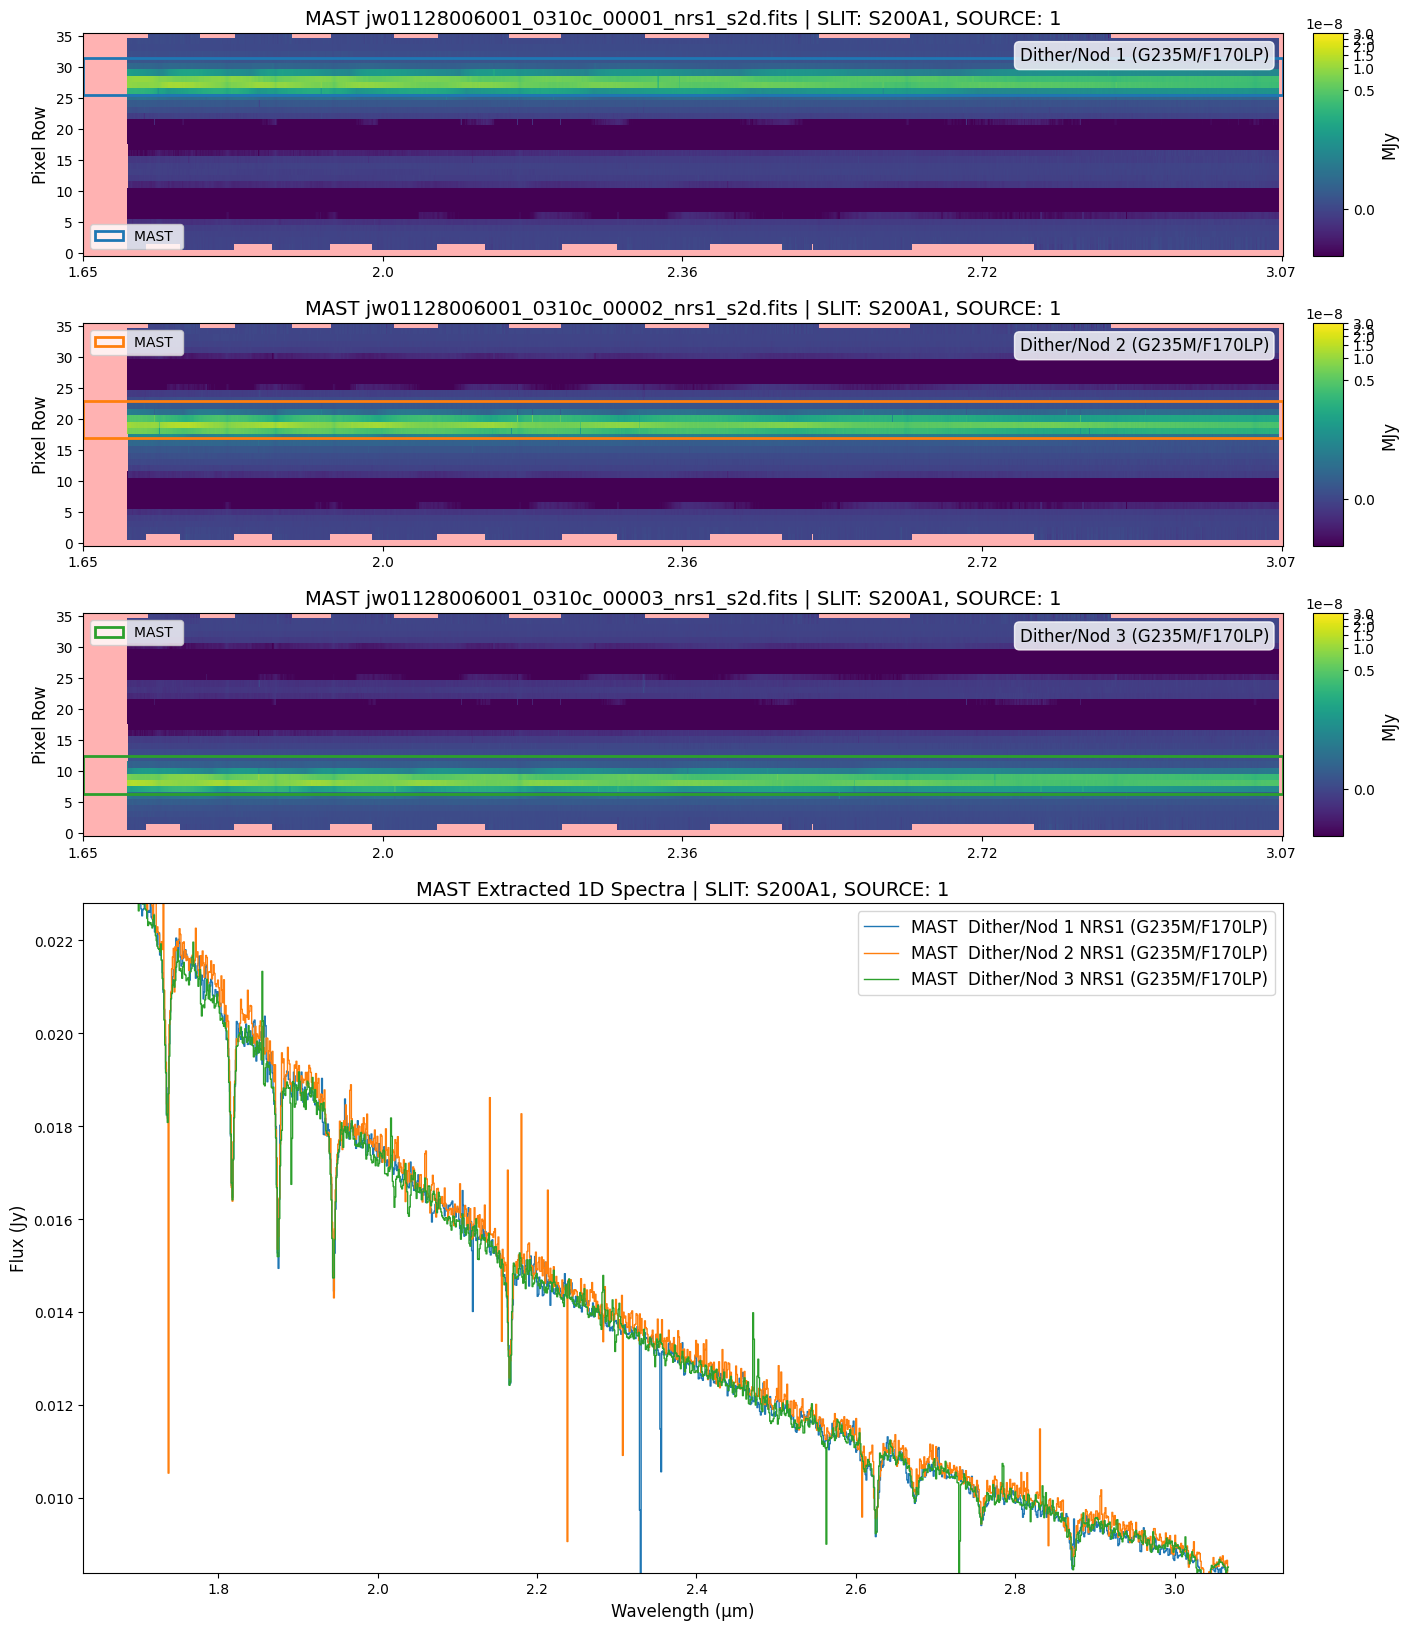

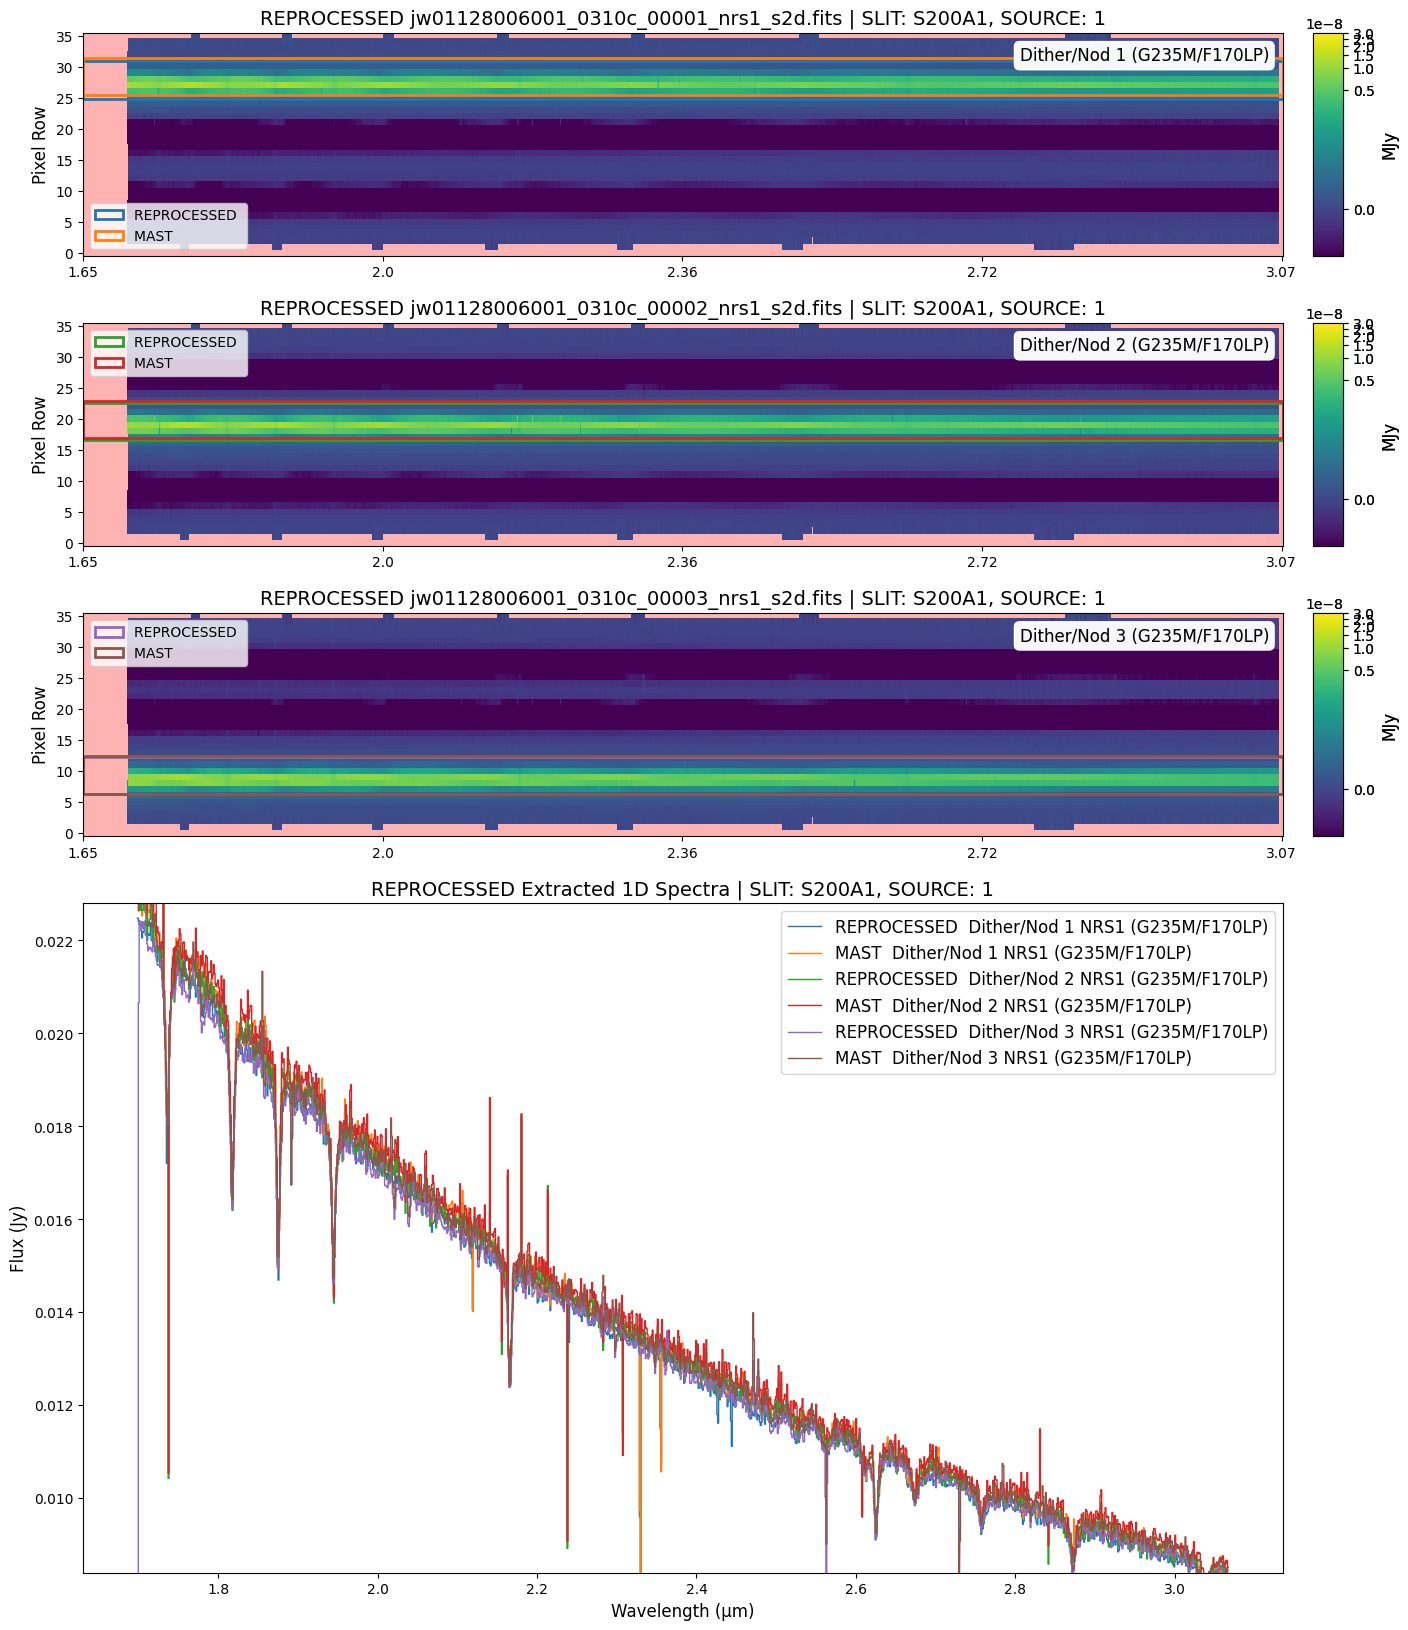

In [30]:
# Display stage 2 products.

# Compare to the data product in MAST?
if compare_mast:

    MAST_s2ds, MAST_x1ds = [], []
    for s2d, x1d in zip(sci_s2d, sci_x1d):
        # Download the MAST data product (or load it if you've downloaded it already).
        MAST_s2d = get_jwst_file(os.path.basename(s2d), save_dir=mast_products_dir)
        MAST_x1d = get_jwst_file(os.path.basename(x1d), save_dir=mast_products_dir)
        MAST_s2ds.append(MAST_s2d)
        MAST_x1ds.append(MAST_x1d)
    display_spectra(MAST_s2ds+MAST_x1ds, source_id='S200A1', scale='log',
                    vmin=-0.1e-9, vmax=3e-8, title_prefix='MAST')

display_spectra(sci_s2d+sci_x1d, source_id='S200A1', scale='log',
                compare_mast=MAST_x1ds if compare_mast else None,
                vmin=-0.1e-9, vmax=3e-8, title_prefix='REPROCESSED')

<div class="alert alert-block alert-info">

**Flux Calibration Updates (Build 11.1rc1)**: Differences in flux calibration are expected due to recent improvements, including updates to spectral resampling, new F-flat reference files, and improved pathloss corrections for FS data. These changes will be seen in both Stage 2 and Stage 3 products. 

> * **Improved Spectral Resampling (`resample_spec`)**: The spectral resampling for NIRSpec was updated to use a grid uniformly sampled in angular units rather than normalized slit units. This update ensures flux is conserved across different slitlet sizes and 2D extraction box dimensions, resulting in improved consistency for MOS slitlets with varying numbers of shutters.
> * **New MOS/FS F-flat Reference Files**: New F-flat reference files for MOS and FS were delivered to CRDS to work with the updated spectral resampling. These files correct an issue that would have caused an erroneous ~5% change in flux calibration with the new resampling method.
>   * **S1600A1 Calibration Update**: The F-flat for S1600A1 was additionally adjusted to accurately calibrate un-dithered observations (e.g., BOTS) by accounting for over-subtraction caused by neighboring nods. 
> * **Improved Hybrid (Data+Model) FS Pathlosses for Cycle 1/2+ Data**: New pathloss reference files for FS data were delivered to CRDS. These files use data-derived pathlosses at the fixed dither positions and model-based pathlosses elsewhere for slits S200A1/A2. Pathloss corrections are turned off for slits S400A1 and S1600A1, as they are consistent within 1 sigma of observed data at fixed dither positions (minimal pathloss).


</div>

---

## 7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)

In this section, we process our calibrated spectra from Stage 2 (`calwebb_spec2`) through the Spec3 (`calwebb_spec3`) pipeline to create Stage 3 data products.

* **Input**: An ASN file that lists multiple calibrated exposures (`_cal.fits`) in addition to any background exposures (`_x1d.fits`).
* **Output**: A single calibrated product (rectified and unrectified) and 1D spectrum. These data products have units of MJy/sr (or Jy for extracted point-source spectra).
	* `_cal.fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
    * `_crf.fits`: Calibrated 2D (unrectified) spectra whose DQ array has been updated to flag pixels detected as outliers (ncols x nrows).
    * `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows). 
	* `_x1d.fits`: Extracted 1D spectroscopic data.      

The `Spec3Pipeline` performs additional corrections (e.g., outlier detection, background subtraction) and combines calibrated data from multiple exposures (e.g. a dither/nod pattern) into a single 2D spectral product, as well as a combined 1D spectrum.

---

### 7.1 Configure `Spec3Pipeline`

The `Spec3Pipeline` has the following steps available for NIRSpec FS:

> * `assign_mtwcs`: Modifies the WCS output frame in each exposure of a Moving Target (MT) observation association.
> * `master_background`: Master background subtraction.
> * `outlier_detection` : Identification of bad pixels or cosmic-rays that remain in each of the input images.
> * `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
> * `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)

Below, we set up a dictionary that defines how the `Spec3Pipeline` should be configured for FS data. 


<div class="alert alert-warning">

If master background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 

</div>

In [31]:
# Set up a dictionary to define how the Spec3 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['master_background'] = {}, {}
spec3dict['outlier_detection'], spec3dict['pixel_replace'] = {}, {}
spec3dict['resample_spec'], spec3dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files.
# Files should be in the base local directory or provide full path.
# spec3dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
spec3dict['outlier_detection']['skip'] = True

# Master background usage was set up above, propagate that here.
spec3dict['master_background']['skip'] = not master_bg

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
# spec3dict['pixel_replace']['skip'] = False
# spec3dict['pixel_replace']['n_adjacent_cols'] = 5
# spec3dict['pixel_replace']['algorithm'] = 'fit_profile'

# Resample weight_type.
# spec3dict['resample_spec']['weight_type'] = 'exptime'

<div class="alert alert-block alert-info">
    
The outlier detection step can be too aggressive for FS data, and better results may be obtained by turning it off.
</div>

---

### 7.2 Create `Spec3Pipeline` ASN Files

[Stage 3 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_technical.html) for FS data can include `science` and `background` exposure types. A Stage 3 ASN file requires at least one `science` file (there is usually more than one) but can contain multiple `background` files that enable master background subtraction in `calwebb_spec3`. **Note that the science exposures should be in the `_cal.fits` format, while the background exposures must be in the `_x1d.fits` format.**

This notebook downloads Stage 3 ASN files directly from MAST. However, the downloaded ASN files expect the input files to be in the same directory, which is incompatible with our directory structure. In the cell below, we update the expname fields in the ASN files to use absolute paths to ensure the pipeline looks in the correct locations.

In [32]:
# Get list of ALL spec3 ASN files.
spec3_asn = glob.glob(f"{asn_dir}*spec3*asn.json")
print(f"Stage 3 ASN Files:\n{'-'*20}\n" + "\n".join(spec3_asn))

Stage 3 ASN Files:
--------------------
./fs_data_01128/asn/jw01128-o006_20240815t163602_spec3_00003_asn.json


In [33]:
# Convert 'expname' paths in the ASN file to absolute paths.
# Ensures the pipeline can locate the files,
# regardless of the ASN file's location.
update_asn_paths(spec3_asn, exclude_dirs=[mast_products_dir])

jw01128-o006_20240815t163602_spec3_00003_asn.json 'expname' paths have been updated to absolute paths!


In [34]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
with open(spec3_asn[0], 'r') as f_obj:
    asnfile_data = json.load(f_obj)

JSON(asnfile_data, expanded=True)

<IPython.core.display.JSON object>

---

### 7.3 Run `Spec3Pipeline`

Run the science files and, if available, any background files through the `calwebb_spec3` pipeline using the `.call()` method.

In [35]:
# Run Stage 3 pipeline using the custom spec3dict dictionary.

start = time.time()

for s3_asn in glob.glob(asn_dir + '*spec3*asn.json'):

    print(f"Applying Stage 3 Corrections & Calibrations to: {os.path.basename(s3_asn)}")
    spec3_result = Spec3Pipeline.call(s3_asn,
                                      save_results=True,
                                      steps=spec3dict,
                                      output_dir=spec3_dir)

print(f"\nRun time: {round((time.time()-start)/60.0, 1)} min")
print("Hurray ... Stage 3 has been completed!\n")

Applying Stage 3 Corrections & Calibrations to: jw01128-o006_20240815t163602_spec3_00003_asn.json

Run time: 0.8 min
Hurray ... Stage 3 has been completed!



In [36]:
# Print output result details:
# spec3_result.__dict__  # View entire contents.
# spec3_result.meta.filename
# spec3_result.data.shape

---

### 7.4 Display `Spec3Pipeline` Products

Inspect the Stage 3 combined calibrated spectra. If `compare_mast` is enabled, an additional plot will compare the reprocessed results with MAST products, which were processed using the default pipeline parameters. Reprocessing with a newer pipeline version may result in noticeable improvements in data quality.

**Note**: The FITS file naming scheme for Stage 3 “source-based” products is described [here](https://jwst-pipeline.readthedocs.io/en/stable/jwst/data_products/file_naming.html#:~:text=jw93065002001_02101_00001_nrca1_rate.fits-,Stage%203%20file%20names,%EF%83%81,-In%20this%20stage). Stage 3 filenames now use a 9-digit Source ID (previously 6-digit). Some products in MAST may still follow the older 6-digit format. Below, we adjust the filenames to match the older convention so that they can be downloaded from MAST.


In [37]:
# List the Stage 3 products.

stage3_cal = sorted(glob.glob(spec3_dir + '*_cal.fits'))
stage3_s2d = sorted(glob.glob(spec3_dir + '*_s2d.fits'))
stage3_x1d = sorted(glob.glob(spec3_dir + '*_x1d.fits'))

print(f"Stage 3 CAL Products:\n{'-'*20}\n" + "\n".join(stage3_cal))
print(f"Stage 3 S3D Products:\n{'-'*20}\n" + "\n".join(stage3_s2d))
print(f"Stage 3 X1D Products:\n{'-'*20}\n" + "\n".join(stage3_x1d))

Stage 3 CAL Products:
--------------------
./fs_data_01128/Obs006/stage3/jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_cal.fits
Stage 3 S3D Products:
--------------------
./fs_data_01128/Obs006/stage3/jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_s2d.fits
Stage 3 X1D Products:
--------------------
./fs_data_01128/Obs006/stage3/jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_x1d.fits


The file jw01128-o006_s00001_nirspec_f170lp-g235m-s200a1-subs200a1_s2d.fits already exists in the directory. Skipping download.
The file jw01128-o006_s00001_nirspec_f170lp-g235m-s200a1-subs200a1_x1d.fits already exists in the directory. Skipping download.


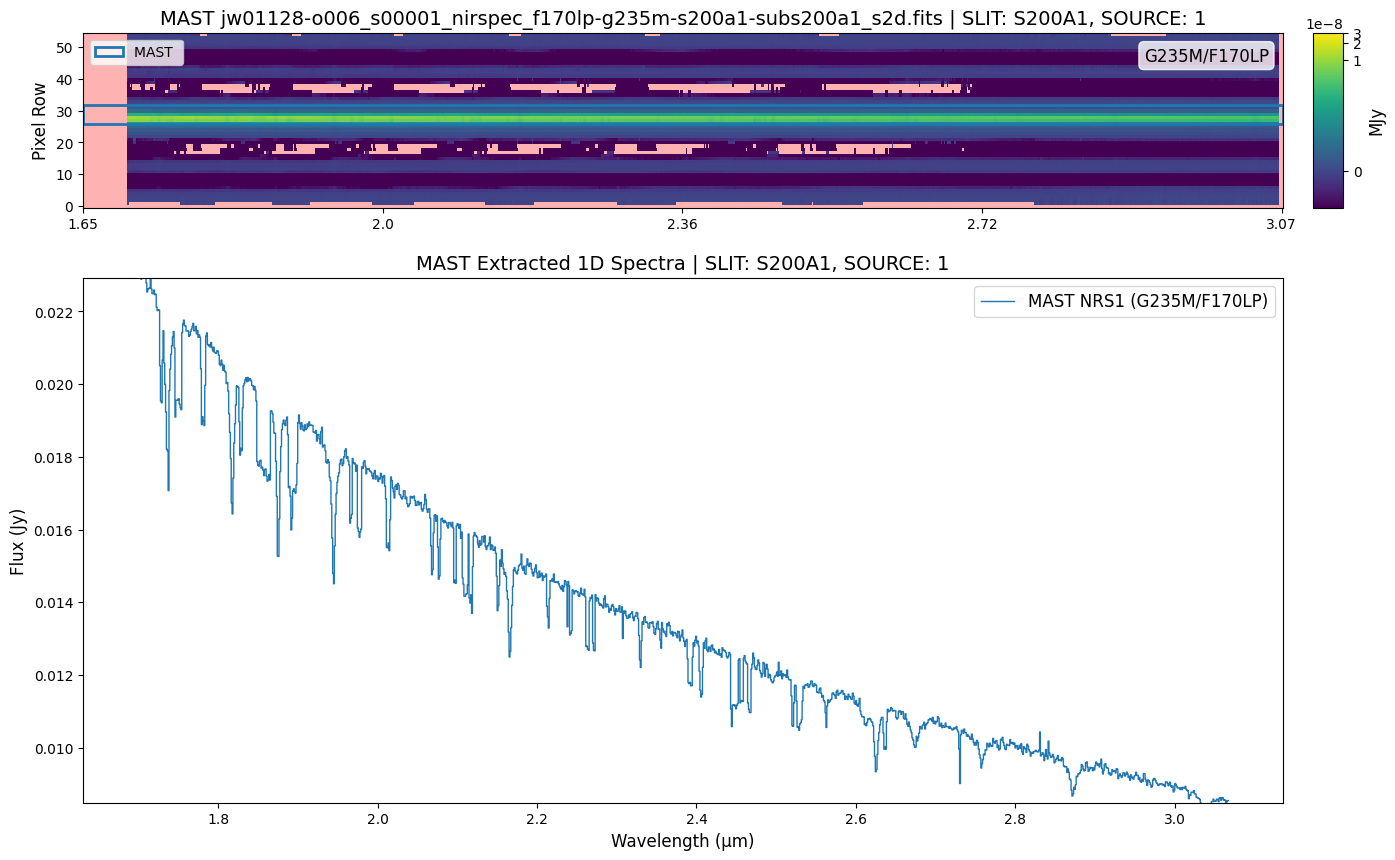

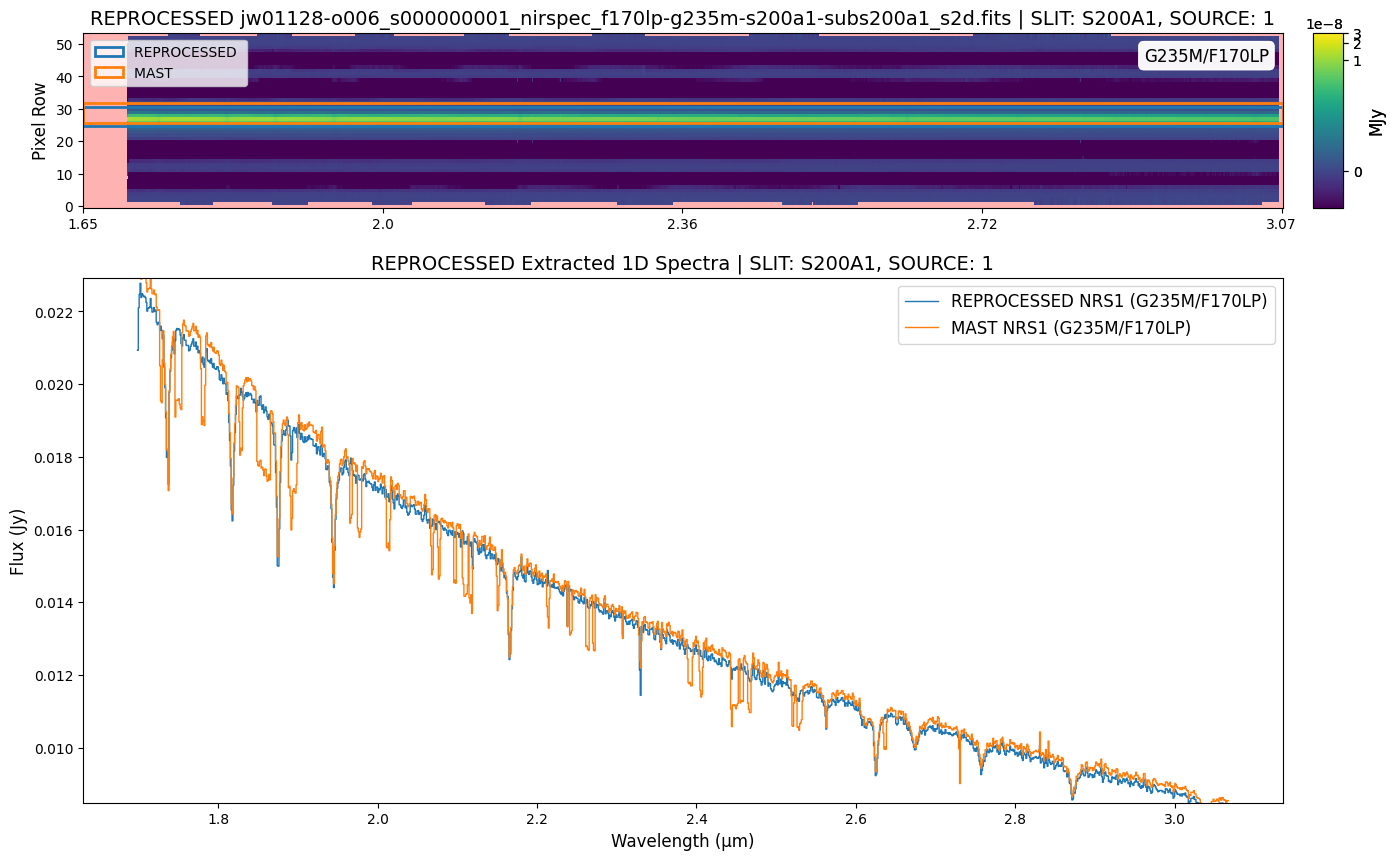

In [38]:
# Display stage 3 products.

# Compare to the data product in MAST?
if compare_mast:

    MAST_s3_s2ds, MAST_s3_x1ds = [], []
    for s2d, x1d in zip(stage3_s2d, stage3_x1d):

        # Convert to old naming format to download from MAST.
        s2d = os.path.basename(s2d).replace('s0000000', 's000')
        x1d = os.path.basename(x1d).replace('s0000000', 's000')

        # Download the MAST data product (or load it if you've downloaded it already).
        MAST_s3_s2d = get_jwst_file(os.path.basename(s2d), save_dir=mast_products_dir)
        MAST_s3_x1d = get_jwst_file(os.path.basename(x1d), save_dir=mast_products_dir)
        MAST_s3_s2ds.append(MAST_s3_s2d)
        MAST_s3_x1ds.append(MAST_s3_x1d)
    display_spectra(MAST_s3_s2ds+MAST_s3_x1ds, source_id='S200A1', scale='log',
                    vmin=-0.1e-9, vmax=3e-8, title_prefix='MAST', is_stage3=True)

display_spectra(stage3_s2d+stage3_x1d, source_id='S200A1', scale='log',
                compare_mast=MAST_s3_x1ds if compare_mast else None,
                vmin=-0.1e-9, vmax=3e-8, title_prefix='REPROCESSED', is_stage3=True)

---

## 8. Modifying the EXTRACT1D Reference File (as needed)

The `extract_1d` step's `use_source_pos` parameter in Stage 2 generally centers the 1D extraction box on the actual source location effectively and thus doesn't usually require manual adjustment. However, in some cases, adjusting the position of the extraction box by modifying the EXTRACT1D reference file may be useful. The following section demonstrates how to do this.

The EXTRACT1D reference file, along with several other parameter files, can be found in the `CRDS_PATH` directory. While some files, like `.json` files, can be manually edited, we modify them using Python.

<div class="alert alert-block alert-danger">
    
**Warning**: Currently, there is no aperture correction in place for NIRSpec, so the `extract_width` parameter **MUST** remain unchanged (6 pixels wide; 5 for S1600A1) to ensure proper flux calibration! The extraction box limits (`ystart` and `ystop`) can be modified; however, if `ystart` and `ystop` do not match the `extract_width`, the `extract_width` takes precedence and is applied symmetrically around the midpoint between `ystart` and `ystop`.

</div>


In [39]:
# Modify the EXTRACT1D reference file.

# If you don't know the reference file name this should work.
# extract_1d_ref = Spec3Pipeline().get_reference_file(stage3_s2d, 'extract1d')

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0008.json'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0008.json']

# Open EXTRACT1D reference file in read-mode.
with open(extract_1d_ref, "r") as ref_file:
    params = json.load(ref_file)

    yshift = -4  # Applied shift in pixels as example.

    # S200A1
    params["apertures"][0]["extract_width"] = 6
    params["apertures"][0]["ystart"] += yshift
    params["apertures"][0]["ystop"] += yshift

    # S200B1
    params["apertures"][1]["extract_width"] = 6
    params["apertures"][1]["ystart"] = 26.5
    params["apertures"][1]["ystop"] = 31.5

    # S200A2
    params["apertures"][2]["extract_width"] = 6
    params["apertures"][2]["ystart"] = 26.5
    params["apertures"][2]["ystop"] = 31.5

    # S400A1
    params["apertures"][3]["extract_width"] = 6
    params["apertures"][3]["ystart"] = 31
    params["apertures"][3]["ystop"] = 36

    # S1600A1
    params["apertures"][4]["extract_width"] = 5
    params["apertures"][4]["ystart"] = 14
    params["apertures"][4]["ystop"] = 18

# Write changes to a new file.
newData = json.dumps(params, indent=4)
# Add the suffix '_fs' to distinguish the file from the default version.
extract_1d_ref_mod = basedir+os.path.basename(extract_1d_ref)[:-5] + "_fs.json"
with open(extract_1d_ref_mod, "w") as file:
    file.write(newData)

In [40]:
# Inspect the EXTRACT1D reference file.
with open(extract_1d_ref_mod, 'r') as f_obj:
    extract_1d_ref_mod_data = json.load(f_obj)

JSON(extract_1d_ref_mod_data, expanded=True)

<IPython.core.display.JSON object>

Now, we re-extract the 1D spectrum by running the `Extract1dStep` and overriding the reference file.


In [41]:
Extract1dStep.call(stage3_s2d,
                   save_results=True,
                   output_dir=spec3_dir,
                   output_use_model=True,
                   suffix='x1d_mod',  # Change suffix to easily find modified file.
                   use_source_posn=False,
                   override_extract1d=extract_1d_ref_mod)

<MultiSpecModel from jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_x1d_mod.fits>

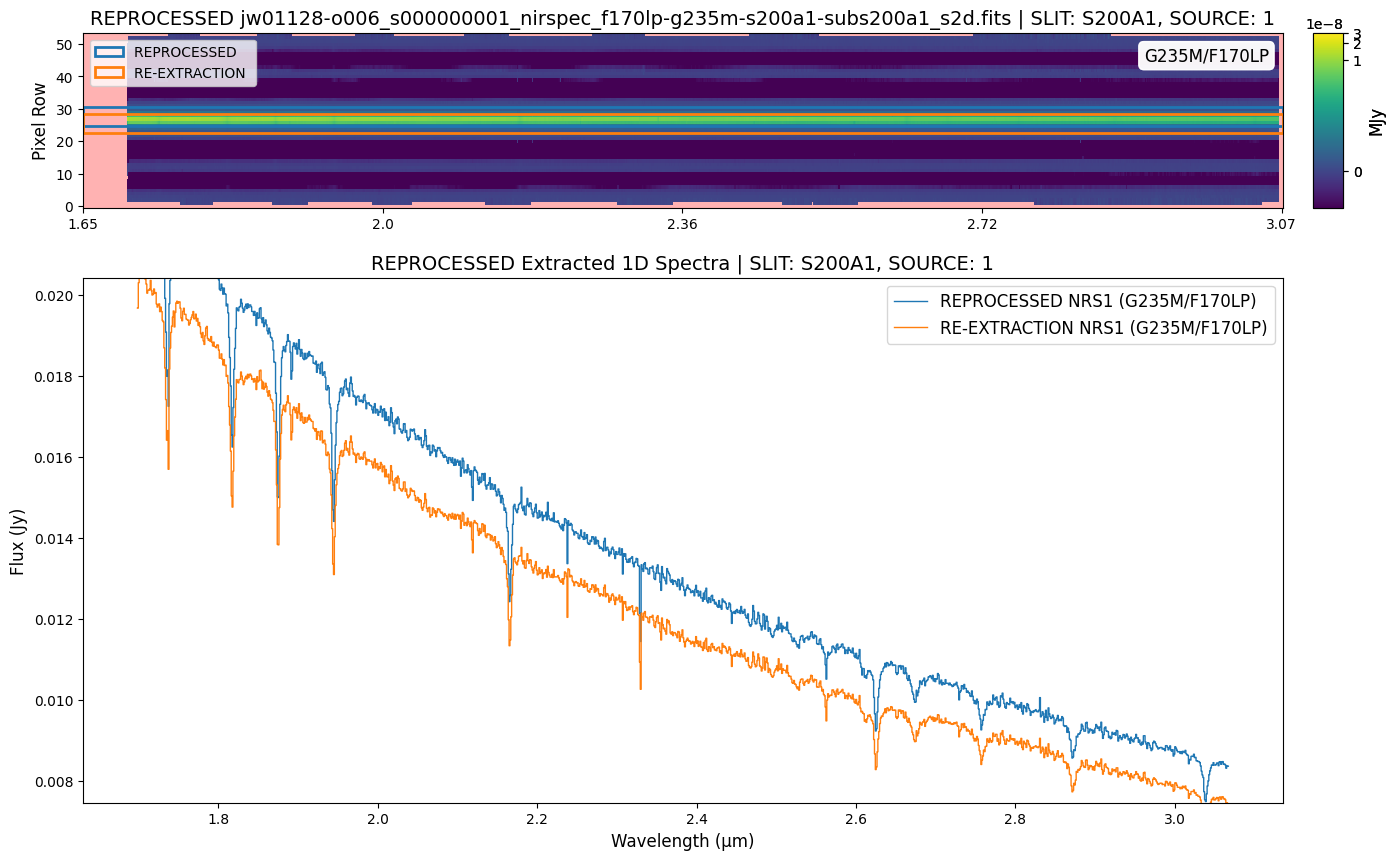

In [42]:
stage3_x1ds_mod = sorted(glob.glob(spec3_dir + '*_x1d_mod.fits'))
display_spectra(stage3_s2d+stage3_x1d, compare_x1d=stage3_x1ds_mod, source_id='S200A1',
                scale='log', vmin=-0.1e-9, vmax=3e-8,
                title_prefix='REPROCESSED', is_stage3=True)

As expected, the spectrum extracted in the shifted location has lower flux that the spectrum extracted in the center of the 2D spectral trace. 

---

<figure>
       <img src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo\" align="right" style="width: 200px"/>
</figure>
   
[Top of Page](#NIRSpec-FS-Pipeline-Notebook)